# Long term forecast results
import all of the long term scenarios and plot the results/summary stats for the paper.

In [1]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import geopandas as gpd
import random

import re
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Import
import the scenarios under each meodelling condition (net-zero production, best in class, housing mixes etc.) -. specific strats are double infill rate, k goes from 0.8->0.5, and best-in-class design.

In [3]:
pop_da = pd.read_csv('C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/FIG_Canada/data/houses/da_pop2021.csv').set_index('DAUID')
pop_da = pop_da[~pop_da.index.duplicated(keep='first')]
pop_da

,pop_2021
DAUID,
10010165,500.0
10010166,340.0
10010167,407.0
10010168,523.0
10010169,285.0
...,...
62080024,423.0
62080025,514.0
62080026,868.0


In [4]:
p_r = "C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/Fig_Canada/results/long-term/"

scenarios = ['Projection scenario LG', 'Projection scenario M1', 'Projection scenario M2', 'Projection scenario M3', 'Projection scenario M4', 'Projection scenario M5',
             'Projection scenario M6', 'Projection scenario HG','Projection scenario SA', 'Projection scenario FA']

f_sf_nz = [pd.read_csv(p_r+'sf_nz_'+ scenario +'.csv', index_col=0) for scenario in scenarios]
f_mm_nz = [pd.read_csv(p_r+'mm_nz_'+ scenario +'.csv', index_col=0) for scenario in scenarios]
f_sf_strats = [pd.read_csv(p_r+'sf_strats_'+ scenario +'.csv', index_col=0) for scenario in scenarios]
f_mm_strats = [pd.read_csv(p_r+'mm_strats_'+ scenario +'.csv', index_col=0) for scenario in scenarios]

In [5]:
## Functions
def convert_ghg_megaton(res_df, pop_da):
    """
    Convert the results to absolute by multiplying
    by population, convert to tonnes from kg (e-3).
    res_df = results dataframe.
    ont_da = from Importer().
    """
    res_df = res_df.join(pop_da, on='DAUID')
    res_df['house_ghg'] = res_df['house_ghg_pp']*res_df['pop_2021']*10**-3
    res_df['road_ghg'] = res_df['road_ghg_pp']*res_df['pop_2021']*10**-3
    res_df['water_ghg'] = res_df['water_inf_ghg_pp']*res_df['pop_2021']*10**-3
    res_df = res_df.drop(['house_ghg_pp','road_ghg_pp','water_inf_ghg_pp'], axis=1)

    return res_df

    
def group_by_iter(res_df, aggr):
    """
    Group the time series results by iteration using some 
    aggregating average.
    res_df = results dataframe.
    aggr = aggregation function.
    """
    res_df_grouped = res_df.groupby(['year', 'iter']).agg(np.sum).reset_index().groupby('year').agg(aggr)

    return res_df_grouped


def group_convert(res_df, ont_da, aggr):
    res_df_c = convert_ghg_megaton(res_df, ont_da)
    res_df_g = group_by_iter(res_df_c, aggr)
    return res_df_g

In [6]:
fg_sf_nz = [group_convert(r, pop_da, np.median) for r in f_sf_nz]
fg_mm_nz = [group_convert(r, pop_da, np.median) for r in f_mm_nz]
fg_sf_strats = [group_convert(r, pop_da, np.median) for r in f_sf_strats]
fg_mm_strats = [group_convert(r, pop_da, np.median) for r in f_mm_strats]

In [7]:
# single family net zero
strats_sf_nz = pd.concat([fg_sf_nz[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(10)], axis=1)
strats_sf_nz_d = pd.concat([fg_sf_nz[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(10)], axis=1)
strats_sf_nz.columns = scenarios
strats_sf_nz_d.columns = scenarios
strats_sf_nz.loc[19] = 0
strats_sf_nz_d.loc[19] = 0

# missing middle net zero
strats_mm_nz = pd.concat([fg_mm_nz[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(10)], axis=1)
strats_mm_nz_d = pd.concat([fg_mm_nz[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(10)], axis=1)
strats_mm_nz.columns = scenarios
strats_mm_nz_d.columns = scenarios
strats_mm_nz.loc[19] = 0
strats_mm_nz_d.loc[19] = 0

# single family combined strats
strats_sf_strats = pd.concat([fg_sf_strats[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(10)], axis=1)
strats_sf_strats_d = pd.concat([fg_sf_strats[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(10)], axis=1)
strats_sf_strats.columns = scenarios
strats_sf_strats_d.columns = scenarios
strats_sf_strats.loc[19] = strats_sf_strats.loc[18] + (strats_sf_strats.loc[18] - strats_sf_strats.loc[17])
strats_sf_strats_d.loc[19] = strats_sf_strats_d.loc[18] + (strats_sf_strats_d.loc[18] - strats_sf_strats_d.loc[17])

# missing middle combined strats
strats_mm_strats = pd.concat([fg_mm_strats[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(10)], axis=1)
strats_mm_strats_d = pd.concat([fg_mm_strats[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(10)], axis=1)
strats_mm_strats.columns = scenarios
strats_mm_strats_d.columns = scenarios
strats_mm_strats.loc[19] = strats_mm_strats.loc[18] + (strats_mm_strats.loc[18] - strats_mm_strats.loc[17])
strats_mm_strats_d.loc[19] = strats_mm_strats_d.loc[18] + (strats_mm_strats_d.loc[18] - strats_mm_strats_d.loc[17])

In [8]:
strats_mm_nz_d

,Projection scenario LG,Projection scenario M1,Projection scenario M2,Projection scenario M3,Projection scenario M4,Projection scenario M5,Projection scenario M6,Projection scenario HG,Projection scenario SA,Projection scenario FA
year,,,,,,,,,,
0,1.841980,4.046547,4.063369,4.059547,4.030192,4.033223,4.049261,5.552218,5.212690,2.149438
1,1.180710,2.685854,2.711566,2.688564,2.682848,2.670790,2.676444,3.804054,3.569390,1.398918
2,0.913104,2.145434,2.159104,2.136220,2.118138,2.133651,2.134582,3.132046,2.945498,1.080683
3,0.826977,2.001299,1.998052,1.997452,1.991280,1.978684,1.991195,3.031472,2.841724,0.972973
4,0.594952,1.472974,1.488611,1.480807,1.473986,1.457234,1.467060,2.319838,2.181332,0.700204
5,0.446636,1.113254,1.116286,1.117636,1.112365,1.108556,1.113888,1.829945,1.716207,0.522047
6,0.342100,0.860244,0.862939,0.859613,0.862036,0.857443,0.857178,1.467653,1.373094,0.402917
7,0.252288,0.648794,0.653268,0.648626,0.650411,0.644161,0.646060,1.152228,1.077025,0.300552
8,0.213757,0.551120,0.554804,0.554044,0.552944,0.548427,0.550425,1.016176,0.949948,0.253239


I also import the short term emissions scenarios that match best with these long term in case we want to plot them behind the long term

In [133]:
# Material Reductions
p_r = "C:/Users/rankin6/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/Fig_Canada/results/short-term/"
names_mat = ['matred_bau_95q_sf','matred_bau_95q_mm']
f_mat = [pd.read_csv(p_r+name+'.csv', index_col=0) for name in names_mat]

# Combined Strategies
names_combi = ['bic_matred_bau_95q_sf','bic_matred_bau_95q_mm']
f_combi = [pd.read_csv(p_r+name+'.csv', index_col=0) for name in names_combi]

fg_mat = [group_convert(r, pop_da, np.median) for r in f_mat]
fg_combi = [group_convert(r, pop_da, np.median) for r in f_combi]

c_names = ['bau_sfq', 'bau_mmq']
# material reductions
strats_mat = pd.concat([fg_mat[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(2)], axis=1)
strats_mat_d = pd.concat([fg_mat[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(2)], axis=1)
strats_mat.columns = c_names
strats_mat_d.columns = c_names

# combi
strats_combi = pd.concat([fg_combi[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(2)], axis=1)
strats_combi_d = pd.concat([fg_combi[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(2)], axis=1)
strats_combi.columns = c_names
strats_combi_d.columns = c_names

Import lock-in potential data where we get 2030 emissions reductions but no more, and no deployment of other strategies

In [10]:
p_r = "C:/Users/Keagan Rankin/OneDrive - University of Toronto/Saxe - Rankin/Project 2. Housing Projections/Fig_Canada/results/long-term/"
f_sf_lockin = [pd.read_csv(p_r+'sf_lockin_'+ scenario +'.csv', index_col=0) for scenario in scenarios]
f_mm_lockin = [pd.read_csv(p_r+'mm_lockin_'+ scenario +'.csv', index_col=0) for scenario in scenarios]

fg_sf_lockin = [group_convert(r, pop_da, np.median) for r in f_sf_lockin]
fg_mm_lockin = [group_convert(r, pop_da, np.median) for r in f_mm_lockin]

In [11]:
# single family lockin
strats_sf_lockin = pd.concat([fg_sf_lockin[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(10)], axis=1)
strats_sf_lockin_d = pd.concat([fg_sf_lockin[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(10)], axis=1)
strats_sf_lockin.columns = scenarios
strats_sf_lockin_d.columns = scenarios
strats_sf_lockin.loc[19] = strats_sf_lockin.loc[18] + (strats_sf_lockin.loc[18] - strats_sf_lockin.loc[17])
strats_sf_lockin_d.loc[19] = strats_sf_lockin_d.loc[18] + (strats_sf_lockin_d.loc[18] - strats_sf_lockin_d.loc[17])

# missing middle lockin
strats_mm_lockin = pd.concat([fg_mm_lockin[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1).cumsum()*10**-6 for i in range(10)], axis=1)
strats_mm_lockin_d = pd.concat([fg_mm_lockin[i][['house_ghg','road_ghg','water_ghg']].sum(axis=1)*10**-6 for i in range(10)], axis=1)
strats_mm_lockin.columns = scenarios
strats_mm_lockin_d.columns = scenarios
strats_mm_lockin.loc[19] = strats_mm_lockin.loc[18] + (strats_mm_lockin.loc[18] - strats_mm_lockin.loc[17])
strats_mm_lockin_d.loc[19] = strats_mm_lockin_d.loc[18] + (strats_mm_lockin_d.loc[18] - strats_mm_lockin_d.loc[17])

Summary stats for 3.3
- when does crossover happen where combined is worse than net zero?
- how many emissions max per year if not good CCU?
- max decrease depending on combined 

In [19]:
print(np.arange(2030, 2051))

[2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043
 2044 2045 2046 2047 2048 2049]


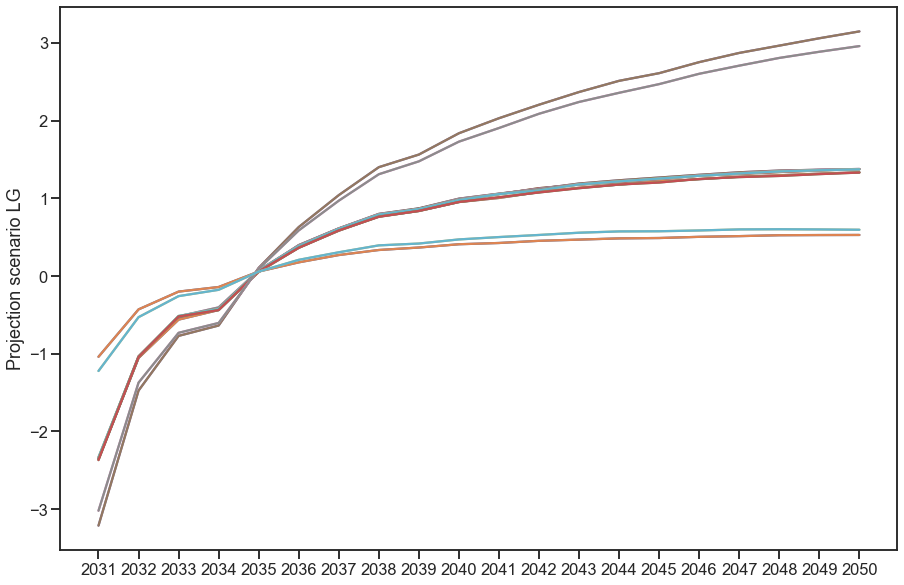

In [25]:
# look at bottom row to see potential 2050 reductions from all strats
strats_mm_strats_d

# you can take the difference and see when savings start happening in net-zero
strats_cross_mm = strats_mm_strats_d - strats_mm_nz_d
strats_cross_sf = strats_mm_strats_d - strats_mm_nz_d

fig, ax = plt.subplots(figsize=(15,10))

for col in strats_cross_mm.columns:
    sns.lineplot(data=strats_cross_mm, x=np.arange(2031, 2051), y=col)
    sns.lineplot(data=strats_cross_sf, x=np.arange(2031, 2051), y=col)

ax.set_xticks(np.arange(2031, 2051))

In [27]:
# worst case yearly emissions
strats_sf_lockin_d

,Projection scenario LG,Projection scenario M1,Projection scenario M2,Projection scenario M3,Projection scenario M4,Projection scenario M5,Projection scenario M6,Projection scenario HG,Projection scenario SA,Projection scenario FA
year,,,,,,,,,,
0,4.440765,10.025769,10.068825,10.008378,10.002448,10.007837,10.027337,13.918495,13.043385,5.189474
1,4.123314,9.718254,9.674658,9.655906,9.638473,9.683427,9.712414,13.913135,13.018497,4.915905
2,3.939561,9.413992,9.419066,9.451382,9.405082,9.428850,9.494340,14.118948,13.164587,4.604727
3,3.730194,9.188917,9.214876,9.207579,9.151664,9.205831,9.258532,14.280624,13.319483,4.426741
4,3.564610,8.964734,8.990025,9.021779,8.934063,8.939421,9.010637,14.452324,13.521598,4.148950
5,3.382225,8.694832,8.756201,8.772244,8.706676,8.681861,8.765845,14.674732,13.726253,3.987429
6,3.270826,8.498659,8.527447,8.513941,8.491652,8.448835,8.577600,14.908377,13.890614,3.840219
7,3.189112,8.326819,8.355866,8.341074,8.320165,8.238277,8.302894,15.135415,14.125059,3.733780
8,3.097680,8.133921,8.163820,8.173484,8.142458,8.062940,8.154979,15.412312,14.425800,3.664677


## Plotting
plot the scenarios, pay attention to comparison between net-zero material production vs. other strategies to 2050

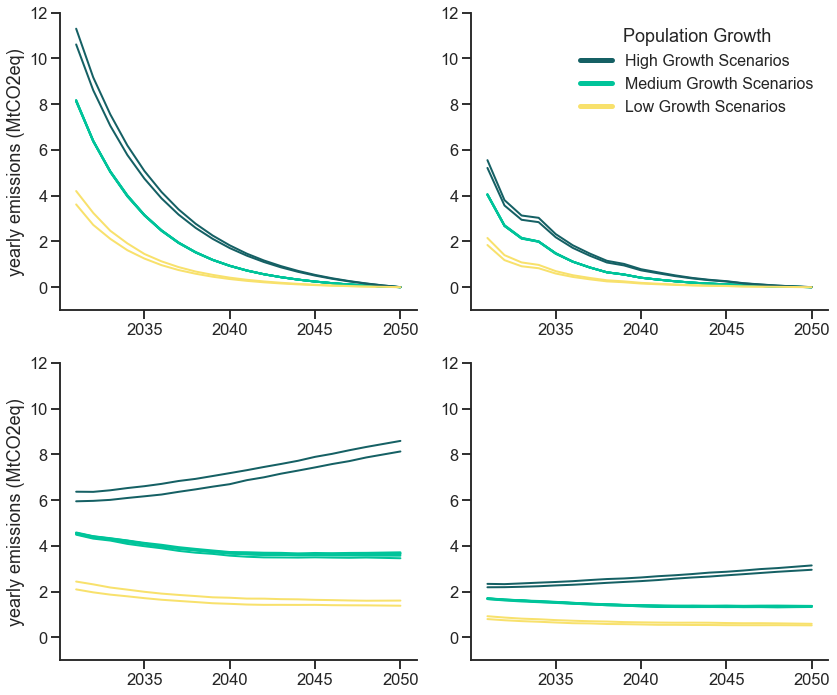

In [12]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
pals = ['#F8E16C', 
        '#00C49A','#00C49A','#00C49A','#00C49A','#00C49A','#00C49A',
        '#156064', '#156064', '#F8E16C']

for i, c in enumerate(strats_sf_nz_d.columns):
    sns.lineplot(ax=ax[0,0], data=strats_sf_nz_d, x=np.arange(2031,2051), y=c, 
                 color=pals[i], linewidth=2)

for i, c in enumerate(strats_mm_nz_d.columns):
    sns.lineplot(ax=ax[0,1], data=strats_mm_nz_d, x=np.arange(2031,2051), y=c, 
                 color=pals[i], linewidth=2)
    
for i, c in enumerate(strats_sf_strats_d.columns):
    sns.lineplot(ax=ax[1,0], data=strats_sf_strats_d, x=np.arange(2031,2051), y=c, 
                 color=pals[i], linewidth=2)
    
for i, c in enumerate(strats_mm_strats_d.columns):
    sns.lineplot(ax=ax[1,1], data=strats_mm_strats_d, x=np.arange(2031,2051), y=c, 
                 color=pals[i], linewidth=2)

for a in ax.reshape(-1):
    a.set_ylim([-1,12])
    a.spines[['top','right']].set_visible(False)
    a.set_ylabel('')
    a.set_xticks([2035, 2040, 2045, 2050])
ax[0,0].set_ylabel('yearly emissions (MtCO2eq)')
ax[1,0].set_ylabel('yearly emissions (MtCO2eq)')

# legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#156064', lw=5, linestyle='solid'),
                Line2D([0], [0], color='#00C49A', lw=5),
                Line2D([0], [0], color='#F8E16C', lw=5),]

ax[0,1].legend(custom_lines, ['High Growth Scenarios','Medium Growth Scenarios','Low Growth Scenarios'], frameon=False,
             title='Population Growth', fontsize=16
             #loc=(-0.33, -0.3), ncol=1
            )

plt.tight_layout()

<b> What if we do a range where the top is 100% single family and the bottom is 100% missing middle? </b>

In [302]:
# for the sf dataframes, take the max value in each row for set of L, M, H columns
low_g = [0, 9]
med_g = [1, 2, 3, 4, 5, 6]
high_g = [7, 8]
nz_highs = pd.DataFrame({'low growth': strats_sf_nz_d.iloc[:, low_g].max(axis=1),
                         'med growth': strats_sf_nz_d.iloc[:, med_g].max(axis=1),
                         'high growth': strats_sf_nz_d.iloc[:, high_g].max(axis=1)})

st_highs = pd.DataFrame({'low growth': strats_sf_strats_d.iloc[:, low_g].max(axis=1),
                         'med growth': strats_sf_strats_d.iloc[:, med_g].max(axis=1),
                         'high growth': strats_sf_strats_d.iloc[:, high_g].max(axis=1)})

# for the mm dataframes, take the min value in each row for set of L, M, H columns
nz_lows = pd.DataFrame({'low growth': strats_mm_nz_d.iloc[:, low_g].min(axis=1),
                        'med growth': strats_mm_nz_d.iloc[:, med_g].min(axis=1),
                        'high growth': strats_mm_nz_d.iloc[:, high_g].min(axis=1)})

st_lows = pd.DataFrame({'low growth': strats_mm_strats_d.iloc[:, low_g].min(axis=1),
                        'med growth': strats_mm_strats_d.iloc[:, med_g].min(axis=1),
                        'high growth': strats_mm_strats_d.iloc[:, high_g].min(axis=1)})

# lock in averaging
li_mean_sf = pd.DataFrame({'low growth': strats_sf_lockin_d.iloc[:, low_g].mean(axis=1),
                           'med growth': strats_sf_lockin_d.iloc[:, med_g].mean(axis=1),
                           'high growth': strats_sf_lockin_d.iloc[:, high_g].mean(axis=1)})

li_mean_mm = pd.DataFrame({'low growth': strats_mm_lockin_d.iloc[:, low_g].mean(axis=1),
                           'med growth': strats_mm_lockin_d.iloc[:, med_g].mean(axis=1),
                           'high growth': strats_mm_lockin_d.iloc[:, high_g].mean(axis=1)})

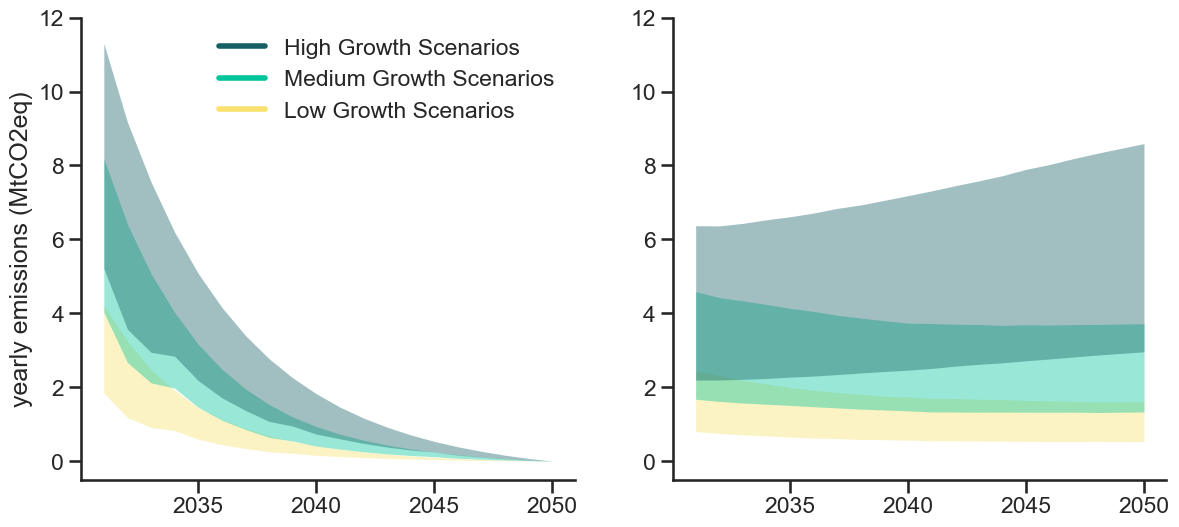

In [237]:
# plot the growth emissions under a range of housing scenarios with fill between
gs = ['low growth', 'med growth', 'high growth']

# inits
fig, ax = plt.subplots(1, 2, figsize=(14,6))
pals = ['#F8E16C', '#00C49A','#156064']
#pals = ['#FE218B', '#FED700', '#21B0FE']

# plot
# net zero
for i, growth in enumerate(gs):
    ax[0].fill_between(x=np.arange(2031,2051), y1=nz_highs[growth], y2=nz_lows[growth],
                       alpha=0.4, color=pals[i], linewidth=0)

# combined strategies   
for i, growth in enumerate(gs):
    ax[1].fill_between(x=np.arange(2031,2051), y1=st_highs[growth], y2=st_lows[growth],
                       alpha=0.4, color=pals[i], linewidth=0)
    

# Options
for a in ax.reshape(-1):
    a.set_ylim([-0.5,12])
    a.spines[['top','right']].set_visible(False)
    a.set_ylabel('')
    a.set_xticks([2035, 2040, 2045, 2050])
ax[0].set_ylabel('yearly emissions (MtCO2eq)')


# legend
custom_lines = [Line2D([0], [0], color=pals[2], lw=4, linestyle='solid'),
                Line2D([0], [0], color=pals[1], lw=4),
                Line2D([0], [0], color=pals[0], lw=4),]

ax[0].legend(custom_lines, ['High Growth Scenarios','Medium Growth Scenarios','Low Growth Scenarios'], frameon=False,
             #title='Population Growth', fontsize=16, title_fontsize=16
             #loc=(-0.33, -0.3), ncol=1
            )

Adding 2023-2030 simulation

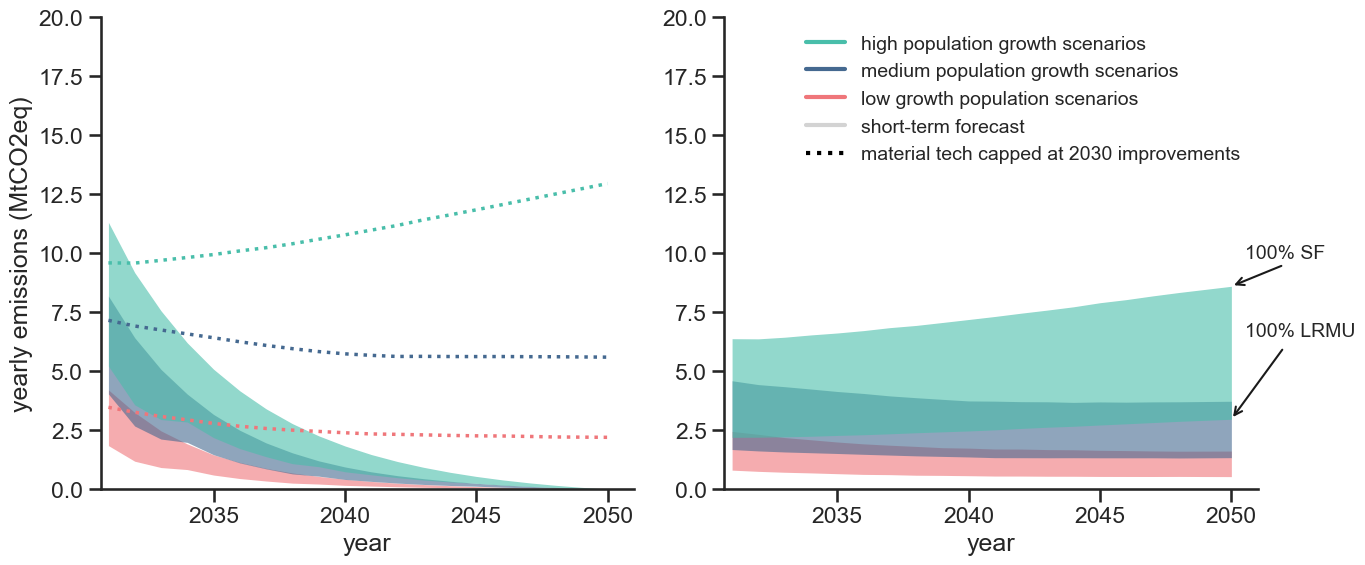

In [316]:
# plot the growth emissions under a range of housing scenarios with fill between
gs = ['low growth', 'med growth', 'high growth']
#hfont = {'fontname':'Arial Nova'}

# inits
fig, ax = plt.subplots(1, 2, figsize=(14,6))
pals = ['#F8E16C', '#00C49A','#156064']
pals = ['#FE218B', '#FED700', '#21B0FE']
pals = ['#ef767a', '#456990', '#49beaa']

# plot
# 2030
#ax[0].fill_between(x=np.arange(2022, 2031), y1=strats_mat_d.iloc[:,0], y2 = strats_mat_d.iloc[:,1],
#                   color='lightgrey', alpha=0.7, linewidth=0)
#ax[1].fill_between(x=np.arange(2022, 2031), y1=strats_combi_d.iloc[:,0], y2 = strats_combi_d.iloc[:,1],
#                   color='lightgrey', alpha=0.7, linewidth=0)

# try the lockin plot
for i, c in enumerate(li_mean_sf.columns):
    sns.lineplot(ax=ax[0], x=np.arange(2031,2051), y=pd.concat([li_mean_mm, li_mean_sf], axis=1)[c].mean(axis=1),
                 color=pals[i], linewidth=2.5, linestyle='dotted')

# net zero
for i, growth in enumerate(gs):
    ax[0].fill_between(x=np.arange(2031,2051), y1=nz_highs[growth], y2=nz_lows[growth],
                       alpha=0.6, color=pals[i], linewidth=0)

# combined strategies   
for i, growth in enumerate(gs):
    ax[1].fill_between(x=np.arange(2031,2051), y1=st_highs[growth], y2=st_lows[growth],
                       alpha=0.6, color=pals[i], linewidth=0)
    

# Options
for a in ax.reshape(-1):
    a.set_ylim([-0.0,20])
    a.set_xlim([2030.7, 2051])
    a.spines[['top','right']].set_visible(False)
    a.set_ylabel('')
    a.set_xlabel('year')
    a.set_xticks([2035, 2040, 2045, 2050])
ax[0].set_ylabel('yearly emissions (MtCO2eq)')

#ax[0].axhline(0, linestyle='--', color='k', alpha=0.2)
#ax[1].axhline(0, linestyle='--', color='k', alpha=0.2)


# legend and text
custom_lines = [Line2D([0], [0], color=pals[2], lw=3, linestyle='solid'),
                Line2D([0], [0], color=pals[1], lw=3),
                Line2D([0], [0], color=pals[0], lw=3),
                Line2D([0], [0], color='lightgrey', lw=3),
                Line2D([0], [0], color='black', lw=3, linestyle='dotted')]

ax[1].legend(custom_lines, ['high population growth scenarios','medium population growth scenarios','low growth population scenarios', 
                            'short-term forecast', 'material tech capped at 2030 improvements'], frameon=False,
             fontsize=14,
             #title='Population Growth', fontsize=16, title_fontsize=16
             #loc=(-0.33, -0.3), ncol=1
            )


ax[1].annotate('', (2050, 8.591661), xytext=(2052, 9.5), arrowprops=dict(arrowstyle='->', color='k'), color='k', fontsize=14)
#ax[1].annotate('', (2050, 3.720634), xytext=(2052, 9.5), arrowprops=dict(arrowstyle='->', color='#456990'), color='k', fontsize=14)
#ax[1].annotate('', (2050, 1.610820), xytext=(2052, 9.5), arrowprops=dict(arrowstyle='->', color='#ef767a'), color='k', fontsize=14)

ax[1].annotate('', (2050, 2.958155), xytext=(2052, 6), arrowprops=dict(arrowstyle='->', color='k'), color='k', fontsize=14)

ax[1].text(2050.5, 9.8, '100% SF', fontsize=14)
ax[1].text(2050.5, 6.5, '100% LRMU', fontsize=14)

#ax[0].text(2023, 6, '100% LRMU', fontsize=14, rotation=-15)
#ax[0].text(2025, 18, '100% SF', fontsize=14, rotation=-15)
#ax[1].text(2023, 2.8, '100% LRMU', fontsize=14, rotation=-5)
#ax[1].text(2025, 11.3, '100% SF', fontsize=14, rotation=-12)

plt.tight_layout()

## Summary statistics
for body of paper

In [329]:
strats_sf_lockin_d.loc[19].max()

18.77138405925336

In [330]:
# 2030 emissions varying in fig a
print('highest 2030', nz_highs['high growth'].loc[0])
print('lowest 2030', nz_lows['low growth'].loc[0])

# 2050 emissions above net zero in lock-in
print('highest lockin', strats_sf_lockin_d.loc[19].max())
print('lowest lockin', strats_mm_lockin_d.loc[19].min())


# lowest possible emissions without net zero in 2050
print('lowest non nz policy scenario', st_lows['low growth'].loc[19])

highest 2030 11.299688847641333
lowest 2030 1.841979572266287
highest lockin 18.77138405925336
lowest lockin 1.2427137391468344
lowest non nz policy scenario 0.5281605479091835
